# Mouse Primary Motor Cortex Data Integration using scJoint

In this tutorial, we will illustrate the utility of scJoint step to integrate data from transcriptomics, chromatin accessbility and methylation, using the data generated from mouse primary motor cortex in Yao et al. 2020 (doi: https://doi.org/10.1101/2020.02.29.970558). The data includes 9 technologies/platforms (7 for RNA: scRNA SMART, scRNA 10x v3, scRNA 10x v2, snRNA SMART, snRNA 10x v3 B, snRNA 10x v3 A, and snRNA 10x v2; 1 for ATAC: snATAC-seq; 1 for methylation: snmC-seq). For illustration purpose, we only use a subset of the data in this tutorial.

In [1]:
import process_db
import h5py
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import re
random.seed(1)

## Running scJoint

The data have 18603 genes in common, and we have 21 cell types in total in the RNA-seq data, so we will set `number_of_class` as 21 and `input_size` as 18603 in the config.py file. The paths also needed to be edited accordingly. Note that since the RNA-seq data are generated from 7 different technologies, we also need to set `center_weight` to a larger value to increase the batch mixing. Here we will set it as 20. Here are the settings for mouse primary motor cortex data we used:

```
self.number_of_class = 21
self.input_size = 18603
self.rna_paths = ['data_MOp/YaoEtAl_RNA_snRNA_10X_v3_B_exprs.npz',\
                    'data_MOp/YaoEtAl_RNA_snRNA_10X_v3_A_exprs.npz',\
                    'data_MOp/YaoEtAl_RNA_snRNA_10X_v2_exprs.npz',\
                    'data_MOp/YaoEtAl_RNA_snRNA_SMARTer_exprs.npz',\
                    'data_MOp/YaoEtAl_RNA_scRNA_10X_v3_exprs.npz',\
                    'data_MOp/YaoEtAl_RNA_scRNA_10X_v2_exprs.npz',\
                    'data_MOp/YaoEtAl_RNA_scRNA_SMARTer_exprs.npz']
self.rna_labels = ['data_MOp/YaoEtAl_RNA_snRNA_10X_v3_B_cellTypes.txt',\
                    'data_MOp/YaoEtAl_RNA_snRNA_10X_v3_A_cellTypes.txt',\
                    'data_MOp/YaoEtAl_RNA_snRNA_10X_v2_cellTypes.txt',\
                    'data_MOp/YaoEtAl_RNA_snRNA_SMARTer_cellTypes.txt',\
                    'data_MOp/YaoEtAl_RNA_scRNA_10X_v3_cellTypes.txt',\
                    'data_MOp/YaoEtAl_RNA_scRNA_10X_v2_cellTypes.txt',\
                    'data_MOp/YaoEtAl_RNA_scRNA_SMARTer_cellTypes.txt']
self.atac_paths = ['data_MOp/YaoEtAl_ATAC_exprs.npz',\
                    'data_MOp/YaoEtAl_snmC_exprs.npz']
self.atac_labels = ['data_MOp/YaoEtAl_ATAC_cellTypes.txt',\
                    'data_MOp/YaoEtAl_snmC_cellTypes.txt']
self.rna_protein_paths = []
self.atac_protein_paths = []

# Training config			
self.batch_size = 256
self.lr_stage1 = 0.01
self.lr_stage3 = 0.001
self.lr_decay_epoch = 15
self.epochs_stage1 = 10
self.epochs_stage3 = 10
self.p = 0.8
self.embedding_size = 64
self.momentum = 0.9
self.center_weight = 20
self.with_crossentorpy = True
self.seed = 1
self.checkpoint = '' 
```

## Visualisation

The output files of scJoint are stored in `./output` folder. The embeddings are stored in `*_embeddings.txt` files. Dimension reduction methods like tSNE and UMAP can be applied on the embeddings files for visualisations.

In [2]:
output_dir = "data_MOp/output/"
embeddings_file_names = [fn for fn in os.listdir(output_dir)
                         if any(fn.endswith(ext) for ext in ['_embeddings.txt'])]
embeddings_file_names.sort()
embeddings_file_names

['YaoEtAl_ATAC_exprs_embeddings.txt',
 'YaoEtAl_RNA_scRNA_10X_v2_exprs_embeddings.txt',
 'YaoEtAl_RNA_scRNA_10X_v3_exprs_embeddings.txt',
 'YaoEtAl_RNA_scRNA_SMARTer_exprs_embeddings.txt',
 'YaoEtAl_RNA_snRNA_10X_v2_exprs_embeddings.txt',
 'YaoEtAl_RNA_snRNA_10X_v3_A_exprs_embeddings.txt',
 'YaoEtAl_RNA_snRNA_10X_v3_B_exprs_embeddings.txt',
 'YaoEtAl_RNA_snRNA_SMARTer_exprs_embeddings.txt',
 'YaoEtAl_snmC_exprs_embeddings.txt']

In [3]:
embeddings = np.loadtxt(output_dir + embeddings_file_names[0])
batch = np.repeat(re.sub('_embeddings.txt', '', embeddings_file_names[0]), embeddings.shape[0])
for fn in embeddings_file_names[1:]:
    e = np.loadtxt(output_dir + fn)
    embeddings = np.append(embeddings, e, axis=0)
    batch = np.append(batch, np.repeat(re.sub('_embeddings.txt', '', fn), e.shape[0]))
print(embeddings.shape)
print(batch.shape)

(77729, 64)
(77729,)


In [4]:
tsne_results = TSNE(perplexity=30, n_iter = 1000).fit_transform(embeddings)

In [5]:
df = pd.DataFrame()
df['tSNE1'] = tsne_results[:,0]
df['tSNE2'] = tsne_results[:,1]
df['data'] = batch

The prediction results are saved in `*_knn_predictions.txt` which stored the numeric labels of the predictions. The numeric labels can be mapped to the original cell type labels using the `label_to_idx.txt` file in data input folder.

In [6]:
prediction_file_names = [fn for fn in os.listdir(output_dir)
                         if any(fn.endswith(ext) for ext in ['_knn_predictions.txt'])]
#print(prediction_file_names)
atac_prediction = np.loadtxt(output_dir + prediction_file_names[0])
methy_prediction = np.loadtxt(output_dir + prediction_file_names[1])
#print(atac_prediction.shape)
#print(methy_prediction.shape)

In [7]:
# Reading the original labels
data_dir = "data_MOp/"
label_file_names = [fn for fn in os.listdir(data_dir)
                         if any(fn.endswith(ext) for ext in ['cellTypes.txt'])]
label_file_names.sort()
#print(label_file_names)

atac_original = np.loadtxt(data_dir + label_file_names[0])
methy_original = np.loadtxt(data_dir + label_file_names[8])
rna_original = []

for fn in label_file_names[1:8]:
    p = np.loadtxt(data_dir + fn)
    rna_original = np.append(rna_original, p)
    
#print(rna_original.shape)
prediction = np.append(atac_prediction, rna_original)
prediction = np.append(prediction, methy_original)

In [8]:
print(np.mean(atac_original == atac_prediction))
print(np.mean(methy_original == methy_prediction))

0.9070585280080382
0.8902730198276757


The label transfer accuracy rates are 90.7% for ATAC-seq and 89% for methlaytion.

In [9]:
# matching the numeric labels to cell type annotation
label_to_idx = pd.read_csv(data_dir + 'label_to_idx.txt', sep = '\t', header = None)
label_to_idx.shape
label_dic = []
for i in range(label_to_idx.shape[0]):
    label_dic = np.append(label_dic, label_to_idx[0][i][:-2])
    
df['predicted'] = label_dic[prediction.astype(int)]

<AxesSubplot:xlabel='tSNE1', ylabel='tSNE2'>

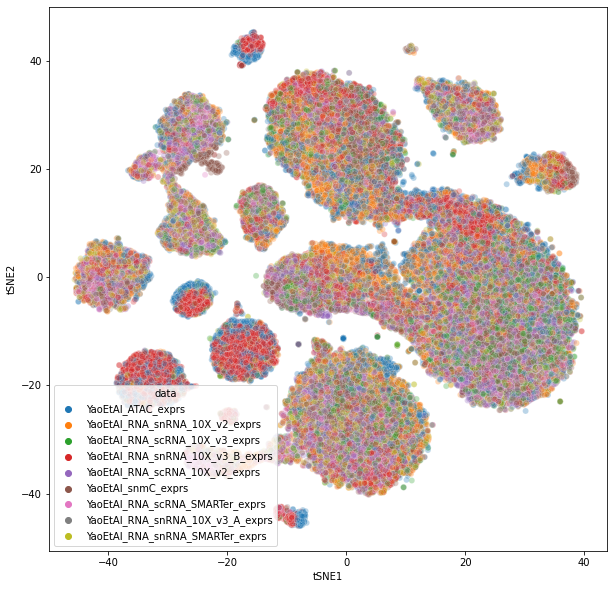

In [10]:
plt.figure(figsize=(10,10))
sns.scatterplot(
    x = "tSNE1", y = "tSNE2",
    hue = "data",
    palette = sns.color_palette("tab10", 9),
    data = df.sample(frac=1),
    legend = "full",
    alpha = 0.3
)

<AxesSubplot:xlabel='tSNE1', ylabel='tSNE2'>

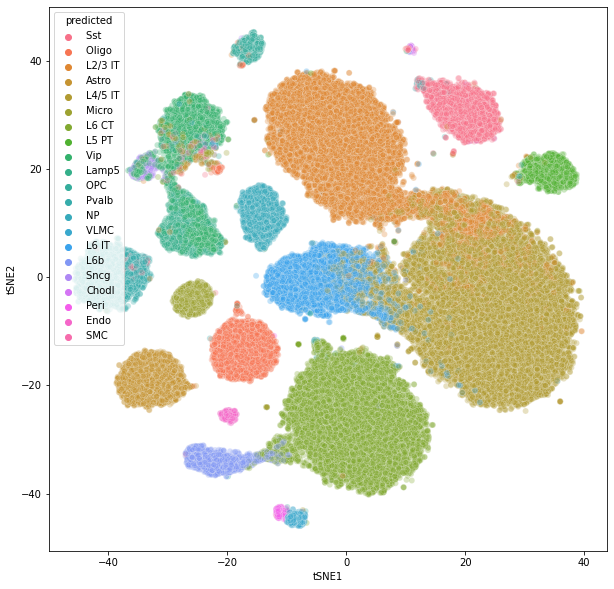

In [11]:
plt.figure(figsize=(10,10))
sns.scatterplot(
    x = "tSNE1", y = "tSNE2",
    hue = "predicted",
    data = df,
    legend = "full",
    alpha = 0.3
)